In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist, to_onehot
import numpy as np
import os 

%matplotlib inline

In [23]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [24]:
root_folder = 'FC_COND_GAN_results'
fixed_folder = root_folder + '/Fixed_results/'
recon_folder = root_folder + '/Recon_results/'

if os.path.isdir(root_folder):
    !rm -r $root_folder
os.mkdir(root_folder)
os.mkdir(fixed_folder)
os.mkdir(recon_folder)

In [25]:
mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
                lambda x: x.to(device)
           ])

In [198]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

lr = 0.0001
prior_size = 100
train_epoch = 1000
batch_size = 250
fixed_z = torch.randn((50, 100))
#z_label = to_onehot(np.random.randint(0, 10, (batch_size)), 10, device)
fixed_label = to_onehot(fixed_label[:100], 10).to(device)
print(fixed_label)
fixed_z_1 = torch.cat((fixed_z, fixed_label), 1)
print(fixed_z_1.shape)
train_loader, valid_loader, test_loader = mnist(batch_size=batch_size, valid=10000, transform=mnist_tanh)
#fixed_z = torch.randn((10, prior_size)).repeat((1,10)).view(-1, prior_size).to(device)
fixed_z_label = to_onehot(torch.tensor(list(range(10))).repeat((10)), 10).to(device)
fixed_data, fixed_label = next(iter(test_loader))
fixed_data = fixed_data[:100].to(device)
fixed_label = to_onehot(fixed_label[:100], 10).to(device)

cpu


RuntimeError: Expected object of scalar type Long but got scalar type Float for argument #3 'index'

In [111]:
for batch_idx, (data, target) in enumerate(train_loader):
  print (data.shape)
  print (data.flatten(1).shape)
  print(target)
  print(to_onehot(target, 10).shape)
  
  N = torch.cat([data.flatten(1), to_onehot(target, 10)], dim=1)
  print(N)
  break

torch.Size([250, 1, 28, 28])
torch.Size([250, 784])
tensor([2, 5, 8, 3, 8, 5, 8, 4, 0, 3, 0, 1, 7, 8, 1, 5, 1, 9, 8, 4, 7, 3, 4, 4,
        6, 4, 6, 6, 5, 8, 6, 0, 5, 6, 4, 5, 7, 3, 6, 9, 6, 8, 7, 8, 3, 6, 2, 9,
        9, 4, 5, 7, 5, 7, 0, 8, 1, 8, 7, 3, 3, 5, 9, 1, 5, 9, 8, 4, 6, 6, 2, 4,
        9, 3, 5, 6, 4, 1, 3, 9, 2, 8, 5, 8, 2, 0, 6, 2, 3, 9, 0, 5, 4, 2, 4, 7,
        5, 2, 3, 4, 5, 3, 0, 0, 6, 4, 9, 1, 0, 4, 8, 2, 3, 7, 1, 7, 7, 4, 8, 7,
        1, 7, 5, 2, 3, 0, 2, 3, 3, 8, 3, 3, 0, 9, 0, 9, 1, 5, 1, 2, 4, 0, 1, 1,
        8, 2, 4, 8, 4, 2, 0, 3, 8, 3, 1, 9, 7, 8, 1, 0, 1, 2, 9, 8, 8, 8, 7, 5,
        2, 7, 3, 2, 9, 2, 2, 4, 5, 3, 3, 5, 1, 1, 4, 1, 9, 6, 3, 6, 5, 4, 0, 3,
        1, 0, 8, 0, 5, 3, 8, 1, 7, 6, 2, 4, 5, 7, 8, 1, 9, 6, 2, 0, 3, 6, 6, 5,
        1, 1, 6, 1, 8, 4, 5, 1, 9, 1, 1, 8, 2, 1, 3, 9, 7, 3, 2, 1, 1, 1, 2, 9,
        4, 6, 3, 1, 8, 0, 4, 0, 1, 5])
torch.Size([250, 10])
tensor([[-1., -1., -1.,  ...,  0.,  0.,  0.],
        [-1., -1., -1.,  ...,  0.,  0.,  

In [112]:
data, label = next(iter(train_loader))

In [113]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh(), flatten=False, 
                 last_fn=None, first_fn=None, device='cpu'):
        super(FullyConnected, self).__init__()
        layers = []
        self.flatten = flatten
        if first_fn is not None:
            layers.append(first_fn)
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn) # нам не нужен дропаут и фнкция активации в последнем слое
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        self.to(device)
        
    def forward(self, x, y=None):
        if self.flatten:
            x = x.view(x.shape[0], -1)
        if y is not None:
            x = torch.cat([x, y], dim=1)
        return self.model(x)

In [114]:
G = FullyConnected([prior_size+10, 256, 512, 1024, 28*28], activation_fn=nn.LeakyReLU(0.2), last_fn=nn.Tanh())
D = FullyConnected([28*28+10, 1024, 512, 256, 1], dropout=0.3, activation_fn=nn.LeakyReLU(0.2), flatten=True)

G_optimizer = optim.Adam(G.parameters(), lr=lr)
D_optimizer = optim.Adam(D.parameters(), lr=lr)

In [115]:
train_log = {'G': [], 'D': []}
test_log = {'G': [], 'D': []}

In [116]:
batch_zeros = torch.zeros((batch_size, 1)).to(device)
batch_ones = torch.ones((batch_size, 1)).to(device)

In [208]:
def train(epoch, G, D, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, label) in enumerate(train_loader):
        #print(label)
        label = to_onehot(label, 10, device)
        #print(label[0])
        #print(label.size())
        # train D
        D.zero_grad()
        G.zero_grad()
        
        z = torch.randn((batch_size, prior_size)).to(device)
        #print(z.size())
        #z_label = to_onehot(np.random.randint(0, 10, (batch_size)), 10, device)
        #print(data.size())
        #print(label.size())
        #fake_pred = D(G(z), label)
        #true_pred = D(data, label)
        #a = torch.cat((z, label ),1) => 250X110
        #G(torch.cat((z, label ),1)) =>250X784
        #print(a.size())

        
        #fake_pred = D(torch.cat((G(torch.cat((z, label ),1)),label),1))
        fake_pred = D(G(torch.cat((z, label ),1)), label)
        true_pred = D(data, label)
        #print(data.size())
        #print(label.size())

        
        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones)
        
        D_loss = 0.5*(fake_loss + true_loss)
        
        D_loss.backward()
        D_optimizer.step()

        
        # train G
        D.zero_grad()
        G.zero_grad()
        z = torch.randn((batch_size, prior_size))
        z_label = to_onehot(np.random.randint(0, 10, (batch_size)), 10)
        #print(z_label.size())
        #fake_pred = D(G(z),z_label)
        fake_pred = D(torch.cat((G(torch.cat((z, z_label ),1)),z_label),1))
        G_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_ones)
        
        G_loss.backward()
        
        G_optimizer.step()
            
        if batch_idx % 100 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = 'G: {:.4f}, D: {:.4f}'.format(G_loss.item(), D_loss.item())
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = 'G: {:.4f}, D: {:.4f}'.format(G_loss.item(), D_loss.item())
        print(line + losses)
        log['G'].append(G_loss.item())
        log['D'].append(D_loss.item())

In [209]:
def test(G, D, loader, epoch, log=None):
    test_size = len(loader)
    G_loss = 0.
    D_loss = 0.
    test_loss = {'G': 0., 'D': 0.}
    with torch.no_grad():
        for data, label in loader:
            label = to_onehot(label, 10, device)
            z = torch.randn((batch_size, prior_size))
            #fake_pred = D(torch.cat((G(torch.cat((z, label ),1)),label),1))
            fake_pred = D(G(torch.cat((z, label ),1)), label)
            true_pred = D(data, label)
        
            fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros).item()
            true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones).item()
            
            D_loss += 0.5*(fake_loss + true_loss)
            G_loss += F.binary_cross_entropy_with_logits(fake_pred, batch_ones).item()
    
    G_loss /= test_size
    D_loss /= test_size

    #fixed_gen = G(fixed_z).data.numpy().reshape(50, 1, 28, 28)
    #plot_mnist(fixed_gen, (5, 10), True, fixed_folder + '/%03d.png' % epoch)
    report = 'Test losses. G: {:.4f}, D: {:.4f}'.format(G_loss, D_loss)
    print(report)

In [213]:
for epoch in range(1, 120):
    G.train()
    D.train()
    train(epoch, G, D, train_log)
    G.eval()
    D.eval()
    test(G, D, valid_loader, epoch, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses G: 1.7785, D: 0.4873
Train Epoch: 1 [25000/50000 (50%)]	Losses G: 1.9631, D: 0.4482
Train Epoch: 1 [50000/50000 (100%)]	Losses G: 1.9189, D: 0.4655
Test losses. G: 1.8228, D: 0.4141
Train Epoch: 2 [0/50000 (0%)]	Losses G: 1.6354, D: 0.4802
Train Epoch: 2 [25000/50000 (50%)]	Losses G: 1.7576, D: 0.4271
Train Epoch: 2 [50000/50000 (100%)]	Losses G: 1.7074, D: 0.3888
Test losses. G: 1.7512, D: 0.3318
Train Epoch: 3 [0/50000 (0%)]	Losses G: 2.0432, D: 0.4052
Train Epoch: 3 [25000/50000 (50%)]	Losses G: 1.6643, D: 0.4419
Train Epoch: 3 [50000/50000 (100%)]	Losses G: 1.7295, D: 0.4166
Test losses. G: 1.7520, D: 0.3946
Train Epoch: 4 [0/50000 (0%)]	Losses G: 1.7477, D: 0.4778
Train Epoch: 4 [25000/50000 (50%)]	Losses G: 1.7871, D: 0.4878
Train Epoch: 4 [50000/50000 (100%)]	Losses G: 1.8460, D: 0.4969
Test losses. G: 1.7015, D: 0.4281
Train Epoch: 5 [0/50000 (0%)]	Losses G: 1.8137, D: 0.4951
Train Epoch: 5 [25000/50000 (50%)]	Losses G: 1.8039, D: 0.4986
Tra

Train Epoch: 38 [25000/50000 (50%)]	Losses G: 1.6369, D: 0.5060
Train Epoch: 38 [50000/50000 (100%)]	Losses G: 1.4312, D: 0.5161
Test losses. G: 1.3607, D: 0.4588
Train Epoch: 39 [0/50000 (0%)]	Losses G: 1.5925, D: 0.5299
Train Epoch: 39 [25000/50000 (50%)]	Losses G: 1.3957, D: 0.5312
Train Epoch: 39 [50000/50000 (100%)]	Losses G: 1.3021, D: 0.5407
Test losses. G: 1.3553, D: 0.4822
Train Epoch: 40 [0/50000 (0%)]	Losses G: 1.2606, D: 0.5291
Train Epoch: 40 [25000/50000 (50%)]	Losses G: 1.2132, D: 0.5240
Train Epoch: 40 [50000/50000 (100%)]	Losses G: 1.2641, D: 0.5834
Test losses. G: 1.2599, D: 0.4952
Train Epoch: 41 [0/50000 (0%)]	Losses G: 1.4876, D: 0.5560
Train Epoch: 41 [25000/50000 (50%)]	Losses G: 1.1350, D: 0.5654
Train Epoch: 41 [50000/50000 (100%)]	Losses G: 1.2050, D: 0.5201
Test losses. G: 1.2385, D: 0.4608
Train Epoch: 42 [0/50000 (0%)]	Losses G: 1.3409, D: 0.4834
Train Epoch: 42 [25000/50000 (50%)]	Losses G: 1.4594, D: 0.4833
Train Epoch: 42 [50000/50000 (100%)]	Losses G: 1

Train Epoch: 75 [25000/50000 (50%)]	Losses G: 1.0703, D: 0.5632
Train Epoch: 75 [50000/50000 (100%)]	Losses G: 0.9643, D: 0.5867
Test losses. G: 0.9837, D: 0.5725
Train Epoch: 76 [0/50000 (0%)]	Losses G: 0.9673, D: 0.5874
Train Epoch: 76 [25000/50000 (50%)]	Losses G: 0.9624, D: 0.6056
Train Epoch: 76 [50000/50000 (100%)]	Losses G: 1.0214, D: 0.6249
Test losses. G: 0.9975, D: 0.5825
Train Epoch: 77 [0/50000 (0%)]	Losses G: 1.0079, D: 0.6163
Train Epoch: 77 [25000/50000 (50%)]	Losses G: 1.1768, D: 0.5221
Train Epoch: 77 [50000/50000 (100%)]	Losses G: 1.1796, D: 0.5515
Test losses. G: 1.1968, D: 0.4778
Train Epoch: 78 [0/50000 (0%)]	Losses G: 1.2381, D: 0.5578
Train Epoch: 78 [25000/50000 (50%)]	Losses G: 0.9671, D: 0.5577
Train Epoch: 78 [50000/50000 (100%)]	Losses G: 1.0267, D: 0.5929
Test losses. G: 0.9995, D: 0.5437
Train Epoch: 79 [0/50000 (0%)]	Losses G: 1.0666, D: 0.6144
Train Epoch: 79 [25000/50000 (50%)]	Losses G: 1.2330, D: 0.5671
Train Epoch: 79 [50000/50000 (100%)]	Losses G: 1

Train Epoch: 112 [25000/50000 (50%)]	Losses G: 1.0247, D: 0.6222
Train Epoch: 112 [50000/50000 (100%)]	Losses G: 0.9696, D: 0.6205
Test losses. G: 1.0087, D: 0.6034
Train Epoch: 113 [0/50000 (0%)]	Losses G: 0.9977, D: 0.5875
Train Epoch: 113 [25000/50000 (50%)]	Losses G: 0.9359, D: 0.6296
Train Epoch: 113 [50000/50000 (100%)]	Losses G: 1.0087, D: 0.6130
Test losses. G: 0.9919, D: 0.6092
Train Epoch: 114 [0/50000 (0%)]	Losses G: 0.9259, D: 0.6266
Train Epoch: 114 [25000/50000 (50%)]	Losses G: 1.1268, D: 0.5846
Train Epoch: 114 [50000/50000 (100%)]	Losses G: 0.9095, D: 0.6596
Test losses. G: 0.9349, D: 0.6343
Train Epoch: 115 [0/50000 (0%)]	Losses G: 0.9314, D: 0.6254
Train Epoch: 115 [25000/50000 (50%)]	Losses G: 0.9742, D: 0.6256
Train Epoch: 115 [50000/50000 (100%)]	Losses G: 0.9181, D: 0.6221
Test losses. G: 0.8937, D: 0.6011
Train Epoch: 116 [0/50000 (0%)]	Losses G: 0.9093, D: 0.6174
Train Epoch: 116 [25000/50000 (50%)]	Losses G: 0.8541, D: 0.6517
Train Epoch: 116 [50000/50000 (100%

torch.Size([10, 110])


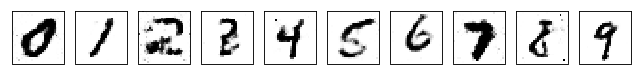

In [218]:
fixed_z = torch.randn((10, 100))
fixed_z_ = torch.cat([fixed_z.flatten(1), to_onehot(torch.LongTensor(np.linspace(0, 9, 10)), 10)], dim=1)
print(fixed_z_.shape)
fixed_gen = G(fixed_z_).data.numpy().reshape(10, 1, 28, 28)
plot_mnist(fixed_gen, (5, 10), True, fixed_folder + '/%03d.png' % epoch)